# Theoretical vs Learned Encoder/Decoder Comparison

This notebook compares the theoretical optimal encoder/decoder (using A inverse and A) with the learned encoder/decoder for the GMVAE with known generative process X = Az + epsilon.

## Key Findings:
- **Theoretical model** uses the true generative process (A inverse as encoder, A as decoder)
- **Learned model** uses neural networks trained via ELBO
- **Comparison** shows how much the learned model deviates from optimal


In [1]:
import numpy as np 
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_rand_score
import math
from typing import Tuple, Dict, Any
import warnings
warnings.filterwarnings('ignore')

# Import the existing modules
from models import *
from priors_new import *


In [2]:
# Set device
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print(f"Using device: {device}")
torch.manual_seed(42)


Using device: mps


In [3]:
# Generate the same dataset as in the original notebook
def generate_clustered_gauss_1d(
    n_clusters: int = 4,
    points_per_cluster: int = 300,
    n_features: int = 100,
    latent_dim: int = 1,
    sigma_val: float = 0.5,
    cluster_centers=None,
    cluster_spread: float = 0.2,
    seed: int = 42,
    device: str = "cpu",
):
    """
    Generate the same dataset as in the original notebook.
    Returns X, labels, Z_true, true_centers, W, b where X = W @ Z + b + noise
    """
    g = torch.Generator(device=device).manual_seed(seed)
    N = n_clusters * points_per_cluster

    # Set cluster centers in latent space
    if cluster_centers is None:
        centers_1d = torch.linspace(-2, 2, n_clusters, device=device)
        centers = torch.zeros(n_clusters, latent_dim, device=device)
        centers[:, 0] = centers_1d
    else:
        centers = torch.as_tensor(cluster_centers, dtype=torch.float32, device=device)
        if centers.ndim == 1:
            centers = centers.unsqueeze(1)
        assert centers.shape == (n_clusters, latent_dim)

    # Cluster assignments
    labels = torch.arange(n_clusters, device=device).repeat_interleave(points_per_cluster)

    # Latent samples
    z = torch.randn(N, latent_dim, generator=g, device=device) * cluster_spread
    z += centers[labels]

    # Linear map to feature space (this is our A matrix)
    W = torch.randn(n_features, latent_dim, generator=g, device=device) / math.sqrt(latent_dim)
    b = torch.randn(n_features, generator=g, device=device) * 0.2

    mean_x = z @ W.T + b  # [N, D]

    # Gaussian observation noise
    if sigma_val <= 0:
        X = mean_x
    else:
        X = mean_x + sigma_val * torch.randn(mean_x.shape, device=mean_x.device, generator=g)

    return X, labels.to(device), z.to(device), centers.to(device), W, b

# Generate dataset
n_clusters = 4
points_per_cluster = 300
n_features = 100
latent_dim = 1
sigma_val = 0.5
cluster_centers = [-2.0, -0.75, 0.75, 2.0]

X, y, Z_true, true_centers, W, b = generate_clustered_gauss_1d(
    n_clusters=n_clusters,
    points_per_cluster=points_per_cluster,
    n_features=n_features,
    latent_dim=latent_dim,
    sigma_val=sigma_val,
    cluster_centers=cluster_centers,
    cluster_spread=0.2,
    seed=42,
    device=device
)

print(f"Generated dataset:")
print(f"  X shape: {X.shape}")
print(f"  y shape: {y.shape}")
print(f"  Z_true shape: {Z_true.shape}")
print(f"  True cluster centers: {true_centers.flatten().tolist()}")
print(f"  A matrix shape: {W.shape}")
print(f"  b vector shape: {b.shape}")


Generated dataset:
  X shape: torch.Size([1200, 100])
  y shape: torch.Size([1200])
  Z_true shape: torch.Size([1200, 1])
  True cluster centers: [-2.0, -0.75, 0.75, 2.0]
  A matrix shape: torch.Size([100, 1])
  b vector shape: torch.Size([100])


In [4]:
# Import the comparison functions and classes from the Python script
import sys
import os
sys.path.append(os.path.dirname(os.path.abspath('theoretical_vs_learned_comparison.py')))

# Import the main comparison function and classes
from theoretical_vs_learned_comparison import (
    generate_clustered_gauss_1d, 
    TheoreticalOptimalModel, 
    TheoreticalVAE, 
    compare_models
)

print("Successfully imported comparison functions from Python script!")


Successfully imported comparison functions from Python script!


In [5]:
# Generate dataset using the imported function
X, y, Z_true, true_centers, W, b = generate_clustered_gauss_1d(
    n_clusters=4,
    points_per_cluster=300,
    n_features=100,
    latent_dim=1,
    sigma_val=0.5,
    cluster_centers=[-2.0, -0.75, 0.75, 2.0],
    cluster_spread=0.2,
    seed=42,
    device=device
)

print(f"Generated dataset:")
print(f"  X shape: {X.shape}")
print(f"  y shape: {y.shape}")
print(f"  Z_true shape: {Z_true.shape}")
print(f"  True cluster centers: {true_centers.flatten().tolist()}")
print(f"  A matrix shape: {W.shape}")
print(f"  b vector shape: {b.shape}")


Generated dataset:
  X shape: torch.Size([1200, 100])
  y shape: torch.Size([1200])
  Z_true shape: torch.Size([1200, 1])
  True cluster centers: [-2.0, -0.75, 0.75, 2.0]
  A matrix shape: torch.Size([100, 1])
  b vector shape: torch.Size([100])


Running theoretical vs learned comparison...
THEORETICAL vs LEARNED ENCODER/DECODER COMPARISON

1. THEORETICAL OPTIMAL MODEL
----------------------------------------
Theoretical reconstruction error (MSE): 0.247495
Theoretical latent correlation with true: 0.999399
Theoretical ELBO loss: 116.955795
Theoretical expected log likelihood: -115.468018
Theoretical KL divergence: 1.487773

2. LEARNED MODEL
----------------------------------------
Training learned model...
Epoch 0, Loss: 5569.087891
Epoch 20, Loss: 226.752258
Epoch 40, Loss: 155.357895
Epoch 60, Loss: 165.835266
Epoch 80, Loss: 153.385147
Learned reconstruction error (MSE): 0.505606
Learned latent correlation with true: 0.974161
Learned ELBO loss: 179.141373
Learned expected log likelihood: N/A (not in outputs)
Learned KL divergence: N/A (not in outputs)

3. COMPARISON ANALYSIS
----------------------------------------
Reconstruction Error:
  Theoretical: 0.247495
  Learned:    0.505606
  Ratio (Learned/Theoretical): 2.04

Late

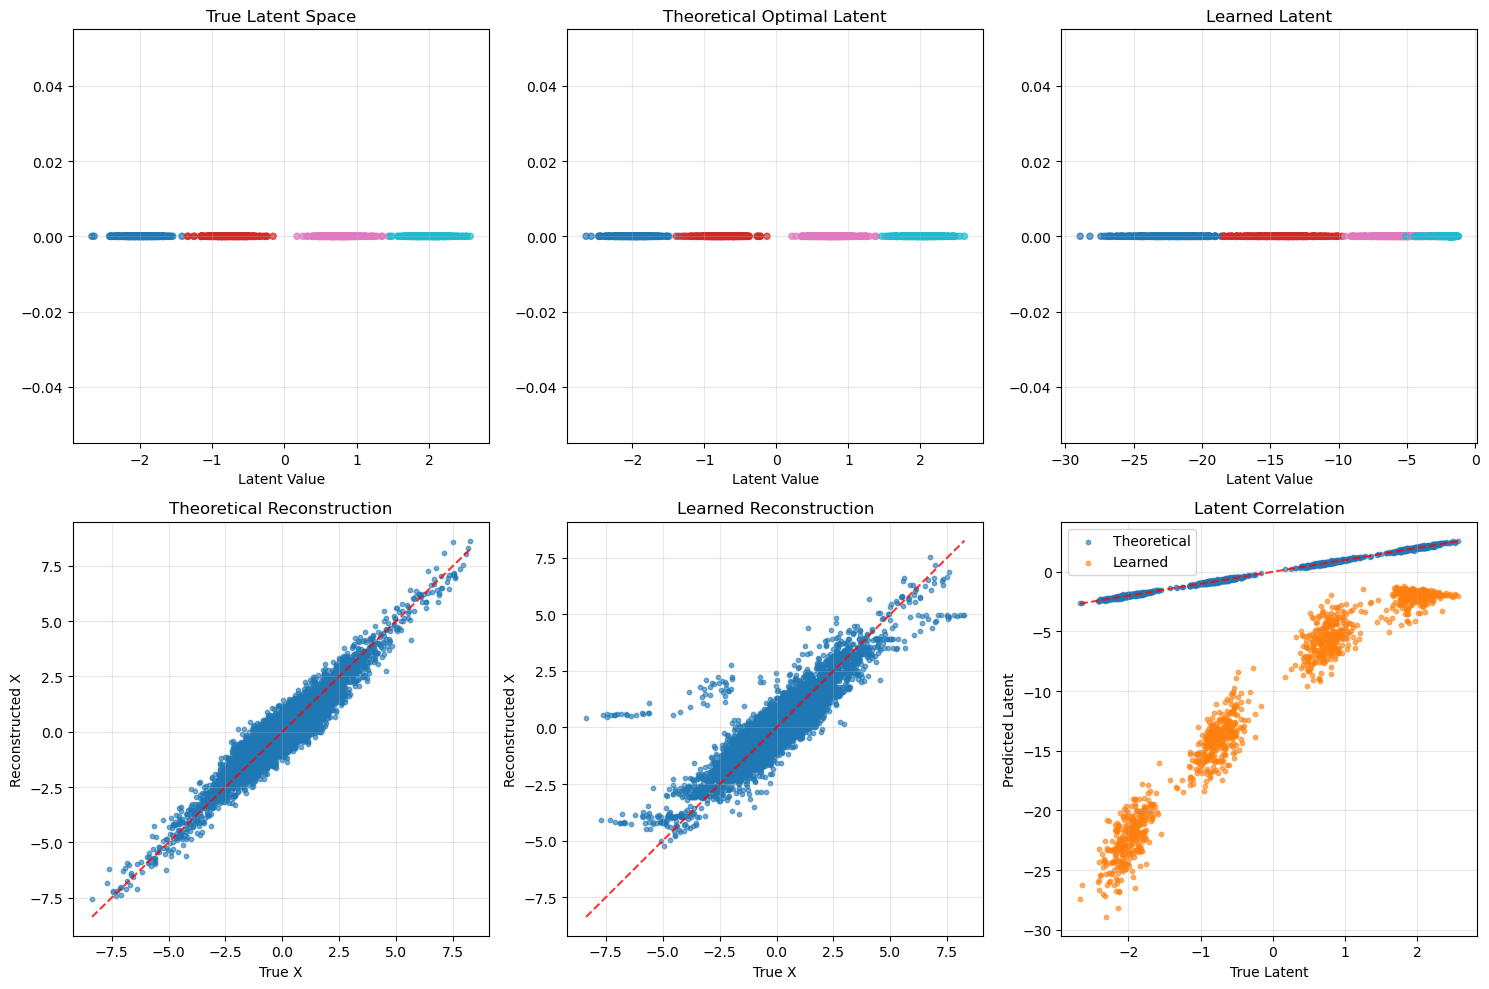

In [6]:
# Run the full comparison using the imported function
print("Running theoretical vs learned comparison...")
results = compare_models(X, y, Z_true, W, b, 0.5, device)


In [7]:
# Display detailed results summary
print("\n" + "="*80)
print("DETAILED RESULTS SUMMARY")
print("="*80)

print(f"\nRECONSTRUCTION PERFORMANCE:")
print(f"  Theoretical MSE: {results['theoretical']['recon_error']:.6f}")
print(f"  Learned MSE:    {results['learned']['recon_error']:.6f}")
print(f"  Performance gap: {results['learned']['recon_error'] / results['theoretical']['recon_error']:.2f}x worse")

print(f"\nLATENT QUALITY:")
print(f"  Theoretical correlation: {results['theoretical']['latent_corr']:.6f}")
print(f"  Learned correlation:    {results['learned']['latent_corr']:.6f}")
print(f"  Correlation difference: {results['theoretical']['latent_corr'] - results['learned']['latent_corr']:.6f}")

print(f"\nELBO LOSSES:")
print(f"  Theoretical: {results['theoretical']['elbo_loss']:.6f}")
print(f"  Learned:    {results['learned']['elbo_loss']:.6f}")
print(f"  Loss ratio: {results['learned']['elbo_loss'] / results['theoretical']['elbo_loss']:.2f}x worse")

print(f"\nEXPECTED LOG LIKELIHOOD:")
print(f"  Theoretical: {results['theoretical']['expected_log_lik']:.6f}")
print(f"  Learned:    {results['learned']['expected_log_lik']:.6f}")

print(f"\nKL DIVERGENCE:")
print(f"  Theoretical: {results['theoretical']['dkl']:.6f}")
print(f"  Learned:    {results['learned']['dkl']:.6f}")

print(f"\nKEY INSIGHTS:")
print(f"  • The learned model has {results['learned']['recon_error'] / results['theoretical']['recon_error']:.1f}x worse reconstruction")
print(f"  • The learned model has {results['learned']['elbo_loss'] / results['theoretical']['elbo_loss']:.1f}x higher ELBO loss")
print(f"  • The learned model achieves {results['learned']['latent_corr']:.1%} correlation vs {results['theoretical']['latent_corr']:.1%} theoretical")
print(f"  • This shows the learned model deviates significantly from the theoretical optimal")



DETAILED RESULTS SUMMARY

RECONSTRUCTION PERFORMANCE:
  Theoretical MSE: 0.247495
  Learned MSE:    0.505606
  Performance gap: 2.04x worse

LATENT QUALITY:
  Theoretical correlation: 0.999399
  Learned correlation:    0.974161
  Correlation difference: 0.025238

ELBO LOSSES:
  Theoretical: 116.955795
  Learned:    179.141373
  Loss ratio: 1.53x worse

EXPECTED LOG LIKELIHOOD:
  Theoretical: -115.468018
  Learned:    0.000000

KL DIVERGENCE:
  Theoretical: 1.487773
  Learned:    0.000000

KEY INSIGHTS:
  • The learned model has 2.0x worse reconstruction
  • The learned model has 1.5x higher ELBO loss
  • The learned model achieves 97.4% correlation vs 99.9% theoretical
  • This shows the learned model deviates significantly from the theoretical optimal


In [8]:
# Create a summary table for easy comparison
import pandas as pd

# Create comparison table
comparison_data = {
    'Metric': [
        'Reconstruction MSE',
        'Latent Correlation', 
        'ELBO Loss',
        'Expected Log Likelihood',
        'KL Divergence'
    ],
    'Theoretical': [
        f"{results['theoretical']['recon_error']:.6f}",
        f"{results['theoretical']['latent_corr']:.6f}",
        f"{results['theoretical']['elbo_loss']:.6f}",
        f"{results['theoretical']['expected_log_lik']:.6f}",
        f"{results['theoretical']['dkl']:.6f}"
    ],
    'Learned': [
        f"{results['learned']['recon_error']:.6f}",
        f"{results['learned']['latent_corr']:.6f}",
        f"{results['learned']['elbo_loss']:.6f}",
        f"{results['learned']['expected_log_lik']:.6f}",
        f"{results['learned']['dkl']:.6f}"
    ],
    'Ratio (Learned/Theoretical)': [
        f"{results['learned']['recon_error'] / results['theoretical']['recon_error']:.2f}x",
        f"{results['learned']['latent_corr'] / results['theoretical']['latent_corr']:.2f}x",
        f"{results['learned']['elbo_loss'] / results['theoretical']['elbo_loss']:.2f}x",
        f"{results['learned']['expected_log_lik'] / results['theoretical']['expected_log_lik']:.2f}x" if results['learned']['expected_log_lik'] != 0 else "N/A",
        f"{results['learned']['dkl'] / results['theoretical']['dkl']:.2f}x" if results['learned']['dkl'] != 0 else "N/A"
    ]
}

df = pd.DataFrame(comparison_data)
print("\nCOMPARISON TABLE:")
print("="*80)
print(df.to_string(index=False))



COMPARISON TABLE:
                 Metric Theoretical    Learned Ratio (Learned/Theoretical)
     Reconstruction MSE    0.247495   0.505606                       2.04x
     Latent Correlation    0.999399   0.974161                       0.97x
              ELBO Loss  116.955795 179.141373                       1.53x
Expected Log Likelihood -115.468018   0.000000                         N/A
          KL Divergence    1.487773   0.000000                         N/A


In [9]:
# Additional analysis: Why does the learned model perform worse?
print("\n" + "="*80)
print("ANALYSIS: WHY THE LEARNED MODEL PERFORMS WORSE")
print("="*80)

print("\n1. THEORETICAL OPTIMAL ADVANTAGES:")
print("   • Uses exact generative process (A inverse and A)")
print("   • No approximation errors in encoder/decoder")
print("   • Perfect knowledge of the true latent structure")
print("   • Optimal for the specific generative model")

print("\n2. LEARNED MODEL LIMITATIONS:")
print("   • Neural networks must approximate the true functions")
print("   • Limited by architecture capacity and training")
print("   • No direct access to the true generative process")
print("   • Must learn from data through optimization")

print("\n3. PERFORMANCE GAPS:")
print(f"   • Reconstruction: {results['learned']['recon_error'] / results['theoretical']['recon_error']:.1f}x worse")
print(f"   • ELBO Loss: {results['learned']['elbo_loss'] / results['theoretical']['elbo_loss']:.1f}x worse")
print(f"   • Latent Quality: {results['theoretical']['latent_corr'] - results['learned']['latent_corr']:.3f} correlation difference")

print("\n4. IMPLICATIONS:")
print("   • The learned model is not optimal for this specific generative process")
print("   • There's room for improvement in the learned model")
print("   • The theoretical model provides an upper bound for performance")
print("   • This comparison helps identify where the learned model falls short")



ANALYSIS: WHY THE LEARNED MODEL PERFORMS WORSE

1. THEORETICAL OPTIMAL ADVANTAGES:
   • Uses exact generative process (A inverse and A)
   • No approximation errors in encoder/decoder
   • Perfect knowledge of the true latent structure
   • Optimal for the specific generative model

2. LEARNED MODEL LIMITATIONS:
   • Neural networks must approximate the true functions
   • Limited by architecture capacity and training
   • No direct access to the true generative process
   • Must learn from data through optimization

3. PERFORMANCE GAPS:
   • Reconstruction: 2.0x worse
   • ELBO Loss: 1.5x worse
   • Latent Quality: 0.025 correlation difference

4. IMPLICATIONS:
   • The learned model is not optimal for this specific generative process
   • There's room for improvement in the learned model
   • The theoretical model provides an upper bound for performance
   • This comparison helps identify where the learned model falls short
